<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import Segmentation as Seg

def getDirection(start, end):
    return [end[0] - start[0], end[1] - start[1]]

def cosAngle(v1, v2):
    return (v1[0]*v2[0] + v1[1]*v2[1]) / (np.sqrt(v1[0]*v1[0] + v1[1]*v1[1]) * np.sqrt(v2[0]*v2[0] + v2[1]*v2[1]))

def findNextPoint(contour, currentPoint, previousDirection):
    candidates = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            if contour[currentPoint[0] + i, currentPoint[1] + j] > 0:
                candidates.append([currentPoint[0] + i, currentPoint[1] + j])
    
    bestIndex = -1
    bestValue = -2
    for i in range(len(candidates)):
        angle = cosAngle(previousDirection, getDirection(currentPoint, candidates[i]))
        if angle > bestValue:
            bestValue = angle
            bestIndex = i
        
    return candidates[bestIndex]

def getContourPointsCW(contour):
    originalPointsY, originalPointsX = np.nonzero(contour)
    index = np.argmin(originalPointsY)
    startingPoint = [originalPointsY[index], originalPointsX[index]] #Topmost point
    
    pointList = [startingPoint, findNextPoint(contour, startingPoint, [0, 1])]
    while True:
        direction = getDirection(pointList[-2], pointList[-1])
        newPoint = findNextPoint(contour, pointList[-1], direction)
        if newPoint == pointList[0]:
            break
        else:
            pointList.append(newPoint)
    return pointList
    

def resampleContour(contour, N):
    originalPoints = getContourPointsCW(contour)
    ys = [x[0] for x in originalPoints]
    xs = [x[1] for x in originalPoints]
    
    originalT = np.arange(len(originalPoints))
    
    newT = np.linspace(0, len(originalPoints), N, False)
    xInterp = np.interp(newT, originalT, xs).astype(int)
    yInterp = np.interp(newT, originalT, ys).astype(int)

    #return np.stack((xInterp, yInterp), axis=1).reshape(-1, 2)
    return yInterp, xInterp
    
    
def resampleAllContours(sequence):
    newSequence = []
    for frame in sequence:
        edges = cv2.Canny(frame, 50, 200).astype(np.uint8)
        Yinterp, Xinterp = resampleContour(edges, 200)
        newSequence.append(np.array([Yinterp, Xinterp]))
    return newSequence
    
    
def interpolateBetweenContours(cStart, cEnd, t): #0 <= t <= 1
    return (1-t)*cStart + t*cEnd


TwoSequence, FourSequence = Seg.getSequenceSegmentations(1)

exampleFile = '2CH_sequence'
image, aspectRatio = Seg.read_patient_mhd_file(1, exampleFile) #Look at 1, 4 ,14, 16
boundary, region = Seg.segmentImage(image[0], aspectRatio, exampleFile, False, True)

<Figure size 640x480 with 1 Axes>

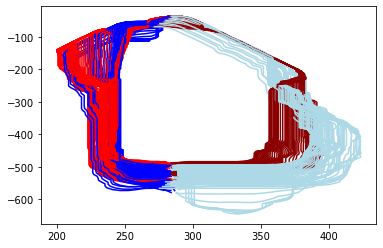

In [2]:
newTwo = resampleAllContours(TwoSequence)
newFour = resampleAllContours(FourSequence)

def interpolateSequence(sequence, numFrames):
    control = np.linspace(0, len(sequence) - 1, numFrames, True)
    fullSequence = []
    for i in control:
        fullSequence.append(interpolateBetweenContours(sequence[int(np.floor(i))], sequence[int(np.ceil(i))], i - np.floor(i)))
    return fullSequence

interpTwo = interpolateSequence(newTwo, 60)
interpFour = interpolateSequence(newFour, 60)
        
#for s in interpFour:
#    plt.plot(s[1], -s[0])
    

def getLeftAndRightContours(c):
    Y = c[0]
    X = c[1]
    index = np.argmin(Y)
    startingPoint = [Y[index], X[index]] #Topmost point
    
    Left = [[], []]
    Right = [[], []]
    for i in range(len(X)):
        if X[i] < startingPoint[1]:
            Left[0].append(Y[i])
            Left[1].append(X[i])
        else:
            Right[0].append(Y[i])
            Right[1].append(X[i])
    Left[0].append(Right[0][0])
    Left[1].append(Right[1][0])
    
    #twoLeft[0] = np.insert(twoLeft[0], 0, twoRight[0][-1])
    #twoLeft[1] = np.insert(twoLeft[1], 0, twoRight[1][-1])
    
    return np.array(Left), np.array(Right), startingPoint
    
def alignContours(two, four):
    twoLeft, twoRight, twoTop = getLeftAndRightContours(two)
    fourLeft, fourRight, fourTop = getLeftAndRightContours(four)
    
    transform = getDirection(fourTop, twoTop)
    
    fourLeft[1] += transform[1]
    fourRight[1] += transform[1]
    fourLeft[0] += transform[0]
    fourRight[0] += transform[0]
    
    plt.plot(twoLeft[1], -twoLeft[0], color='red')
    plt.plot(twoRight[1], -twoRight[0], color='darkred')
    
    plt.plot(fourLeft[1], -fourLeft[0], color='blue')
    plt.plot(fourRight[1], -fourRight[0],  color='lightblue')
    return twoLeft, twoRight, fourLeft, fourRight, twoTop
    
    
def resamplePath(contour, N):
    ys = contour[0]
    xs = contour[1]
    
    originalT = np.arange(contour[0].size)
    
    newT = np.linspace(0, contour[0].size, N, False)
    xInterp = np.interp(newT, originalT, xs).astype(int)
    yInterp = np.interp(newT, originalT, ys).astype(int)

    return np.array([yInterp, xInterp])
    
def generatePointCloud(two, four, intermediateAngles, aspectRatio):
    twoLeft, twoRight, fourLeft, fourRight, twoTop = alignContours(two, four)
    rotationCenter = twoTop[1]
    resampleNumber = 50
    twoLeft = resamplePath(twoLeft, resampleNumber)
    fourLeft = resamplePath(fourLeft, resampleNumber)
    twoRight = resamplePath(twoRight, resampleNumber)
    fourRight = resamplePath(fourRight, resampleNumber)
    points = []
    for i in range(-1, intermediateAngles):
        angle = 90 * (i + 1) / (intermediateAngles + 1)
        interpWeight = angle / 90
        
        interp = interpolateBetweenContours(twoLeft, fourLeft, interpWeight)
        #rotate around y axis, y is constant
        for j in range(len(interp[0])):
            radius = abs(interp[1][j] - rotationCenter)
            points.append([(-radius * np.cos(angle * np.pi / 180)) + rotationCenter, interp[0][j] * aspectRatio, -radius * np.sin(angle * np.pi / 180)]) #Now in x, y, z form
    
    
    for i in range(-1, intermediateAngles):
        angle = 90 * (i + 1) / (intermediateAngles + 1)
        interpWeight = angle / 90
        
        interp = interpolateBetweenContours(fourLeft, np.flip(twoRight, axis = 1), interpWeight)
        #rotate around y axis, y is constant
        for j in range(len(interp[0])):
            radius = abs(interp[1][j] - rotationCenter)
            points.append([(radius * np.sin(angle * np.pi / 180)) + rotationCenter, interp[0][j] * aspectRatio, -radius * np.cos(angle * np.pi / 180)]) #Now in x, y, z form
    
    for i in range(-1, intermediateAngles):
        angle = 90 * (i + 1) / (intermediateAngles + 1)
        interpWeight = angle / 90
        
        interp = interpolateBetweenContours(twoRight, fourRight, interpWeight)
        #rotate around y axis, y is constant
        for j in range(len(interp[0])):
            radius = abs(interp[1][j] - rotationCenter)
            points.append([(radius * np.cos(angle * np.pi / 180)) + rotationCenter, interp[0][j] * aspectRatio, radius * np.sin(angle * np.pi / 180)]) #Now in x, y, z form
    
    
    for i in range(-1, intermediateAngles):
        angle = 90 * (i + 1) / (intermediateAngles + 1)
        interpWeight = angle / 90
         
        interp = interpolateBetweenContours(fourRight, np.flip(twoLeft, axis = 1), interpWeight)
        #rotate around y axis, y is constant
        for j in range(len(interp[0])):
            radius = abs(interp[1][j] - rotationCenter)
            points.append([(-radius * np.sin(angle * np.pi / 180)) + rotationCenter, interp[0][j] * aspectRatio, radius * np.cos(angle * np.pi / 180)]) #Now in x, y, z form
    
    
    
    return points

frames = []
for i in range(len(interpTwo)):
    frames.append(generatePointCloud(interpTwo[i], interpFour[i], 5, aspectRatio))


In [3]:
a = [4, 5, 6,7, 7]
print(np.array(a).size)
print(aspectRatio)

5
0.5


In [11]:
import pyvista as pv

p = pv.wrap(np.array(frames[0]))
surf = p.reconstruct_surface()

pl = pv.Plotter(shape=(1, 2))
pl.add_mesh(p, style='points', point_size=3.0)
pl.add_title('Point Cloud of 3D Surface')
pl.subplot(0, 1)
pl.add_mesh(surf, opacity = 0.4, show_edges=True)
pl.add_title('Reconstructed Surface')
pl.show()

Widget(value="<iframe src='http://localhost:62842/index.html?ui=P_0x1de43d85e48_3&reconnect=auto' style='width…

In [ ]:
import numpy as np

import pyvista as pv

filename = "movie.mp4"


plotter = pv.Plotter()
# Open a movie file
plotter.open_movie(filename)

for i in range(5):
    for frame in frames:
        plotter.clear()
        plotter.add_mesh(pv.wrap(np.array(frame)), style='points', point_size=3.0)
        plotter.write_frame()  # Write this frame
    
plotter.close()